#                                                       UZOP Projekt
*Early-Stage Alzheimer's Disease Prediction Using Machine Learning Models*


*Petra Dunja Grujić Ostojić*

Za projekt iz predmeta Uvod u znanost o podatcima odabrala sam članak koji opisuje primjenu modela strojnog učenja za predviđanje Alzheimerove bolesti. 

Cilj je trenirati modele tako da uoče ranu fazu bolesti kako bi se spriječilo daljnje napredovanje i poboljšala kvaliteta života pacijenata. Primjena strojnog učenja u medicinskoj dijagnostici ima veliki potencijal jer se uz precizne modele postupak može značajno ubrzati i izbjeći pogreške koje su posljedica ljudskih slabosti (subjektivnost, umor, dekoncentracija i slično).
 
Podatkovni skup na kojemu se provodi treniranje modela je javno dostupan skup iz projekta OASIS (Open Access Series of Imaging Studies) koji sam preuzela sa stranice Kaggle (https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers?resource=download). 

Znastvenici su u ovom članku primjenili nekoliko klasifikacijskih algoritama (stroj potpornih vektora, slučajne šume, stabla odluka, XGBoost, klasifikator s glasanjem (engl. Voting Classifier) kako bi predvidjeli ima li pacijent Alzheimer. Temelj predikcije su numerički podatcima dobiveni iz MRI snimaka i nekoliko demografskih podataka. 

## **UČITAVANJE PODATKOVNOG SKUPA I PRVI UVID U PODATKE**


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [80]:
data = pd.read_csv("oasis_longitudinal.csv")
data.rename(columns = {'M/F':'Gender'}, inplace = True)
print(data.shape)
print(data.columns.values)

(373, 15)
['Subject ID' 'MRI ID' 'Group' 'Visit' 'MR Delay' 'Gender' 'Hand' 'Age'
 'EDUC' 'SES' 'MMSE' 'CDR' 'eTIV' 'nWBV' 'ASF']


In [81]:
#data.info()
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,Gender,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034



Analizu podatkovnog skupa započela sam učitavanjem csv datoteke. Podatkovni skup sadrži *373* redaka: 373 MR snimanja ispitanika. Radi se o snimkama *150* pojedinaca (značajka Subject ID). Svaki je pojedinac išao na 1 ili više (do 5) snimanja mozga.
Podatkovni skup sadrži *15* značajki od kojih je jedna značajka monotona (MRI ID-identifikator snimanja) pa ju mogu izbaciti.


Značenje pojedinih značajki:

*   **Subject ID** - identifikacijska oznaka subjekta
*    **MRI ID** - identifikacijska oznaka MR snimanja
*   **Group** - dementni od početka/nedemententi/oni koji su postali dementni tijekom studije
*   **Visit** - redni broj snimanja subjekta
*   **MR Delay** - vrijeme odgode pri MR snimanju 
*   **Gender** - spol
*   **Hand** - ruka kojom osoba piše
*   **Age** - dob
*   **EDUC** - broj godina obrazovanja
*   **SES** - socioekonomski status (5 kategorija)
*   **MMSE** - Mini Mental State Examination (rezultat na testu kognitivnih sposobnosti, maksimalan broj bodova 30)
*   **CDR** - razina demencije
*   **eTIV** - Estimated total intracranial volume - procijenjeni volumen lubanjske šupljine
*   **nWBV** - Normalize Whole Brain Volume - normalizirani volumen mozga
*   **ASF** - Atlas Scaling Factor - faktor transformacije lubanje i mozga za dobivanje MR snimke

U nominalne značajke možemo svrstati: identifikacijske oznake, Group, Visit, Gender, Hand.
U numeričke varijable možemo svrstati: MR Delay, Age, EDUC, MMSE, eTIV, nWBV, ASF.
Neke od ovih varijabli su diskretne (primjerice, MMSE), a neke kontinuirane (primjerice, nWBV).
Varijable SES i CDR su ordinalnog tipa - radi se o brojevima koji predstavljaju kategorije, ali među njima se može uspostaviti poredak.
    


In [82]:
data = data.drop(["MRI ID"], axis = 1)
#provjera monotonosti značajki

print(data.nunique())
print("\nKoliko je ispitanika bilo na pojedinom rednom broju snimanja?")
print(data.Visit.value_counts())
data = data.drop(["Hand"], axis = 1)

Subject ID    150
Group           3
Visit           5
MR Delay      201
Gender          2
Hand            1
Age            39
EDUC           12
SES             5
MMSE           18
CDR             4
eTIV          286
nWBV          136
ASF           265
dtype: int64

Koliko je ispitanika bilo na pojedinom rednom broju snimanja?
1    150
2    144
3     58
4     15
5      6
Name: Visit, dtype: int64


Prvim uvidom u značajke vidim da je prisutna jedna konstantna značajke *Hand* - svi subjekti su dešnjaci pa tu značajku ne trebamo koristiti pri predikciju pa sam je izbrisala. Među subjektima ima i muškaraca i žena te pojedinaca različitog socioekonomskog statusa (značajka SES). Značajkom CDR razlikuju se 4 razine demencije (bez demencija, blaga, umjerena i jaka).
To je posebno važna značajka u ovom podatkovnom skupu pa sam prvo pogledala distribuciju te varijable.


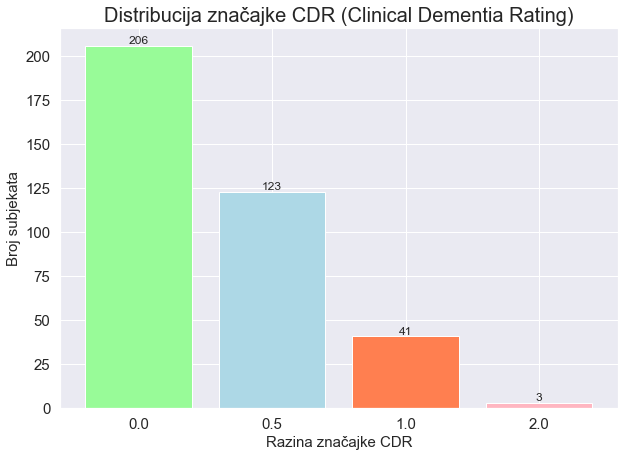

In [83]:
#distribucija značajke CDR

fig, ax = plt.subplots(figsize = (10, 7))
 
frekvencija = data.groupby('CDR').count().loc[:,'Subject ID'].values
razine = data.groupby('CDR').count().index.values
razine = [str(i) for i in razine]

bars = plt.bar(razine, frekvencija, color = ["palegreen", "lightblue", "coral","lightpink"])
ax.bar_label(bars,size = 12)
plt.xlabel("Razina značajke CDR")
plt.ylabel("Broj subjekata")
plt.title("Distribucija značajke CDR (Clinical Dementia Rating)")
ax.title.set_fontsize(20)
for item in ([ ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()



#print(data.CDR.value_counts())



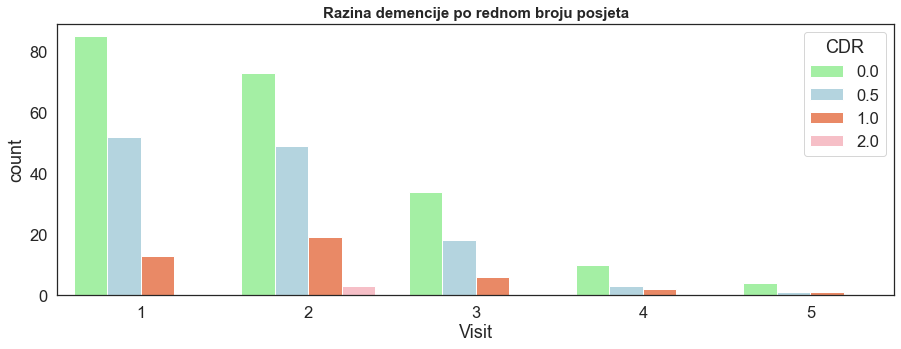

In [84]:
sns.set(font_scale=1.5)
sns.set_style("white") 
fig = plt.figure(figsize = (15,5))
sns.countplot(data=data, x="Visit", hue="CDR",palette = ["palegreen", "lightblue", "coral","lightpink"]).set_title("Razina demencije po rednom broju posjeta",size = 15,weight = "bold");



Za CDR veći ili jednak od 0.5 smatra se da je osoba dementna. Od svih snimanja *206* ih nije pokazalo dementnost,
a samo *3 snimanja* su imala najvišu kategoriju demencije (2).


Pogledamo li razinu demencije po rednom broju posjeta može se primijetiti smanjenje nedementnih subjekata i porast demencije razine 1 u 2. posjetu (u odnosu na prvo snimanje) što znači da imamo dio subjekata koji su za vrijeme studije postali dementni (ili im se pogoršalo stanje).

## **DETEKCIJA STREŠEĆIH I NEDOSTAJUĆIH VRIJEDNOSTI**

Prije daljnje analize i vizualizacije značajki, htjela sam provjeriti ima li u podatkovnom skupu
stršećih i nedostajućih vrijednosti numeričkih i ordinalnih varijabli.
Broj outliera po značajki:
* **MR Delay** - 8 (izbačeni)
* **Age** - 0
* **EDUC** - 3 (iznadprosječno visokoobrazovani subjekti; izbačeni)
* **SES** - 7 (u cijelom skupu ima samo 7 pojedinaca s najvišom kategorijom SES-a; ostavljeni radi demografske raznolikosti)
* **MMSE** - 42 (ostavila sam ih jer ih je puno u odnosu na broj subjekata, svi su dementni što objašnjava niži rezultat od većine)
* **CDR** - 3 (ostavljeni kako bi u skupu imali i jako dementne pojedince)
* **eTIV** - 2 (izbačeni)
* **nWBV** - 0
* **ASF** - 1 (izbačen)
        
            
Nakon izbacivanja ostali su podatci za 359 snimanja.            

In [85]:
numericke = ['MR Delay', 'Age','EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
data2 = data.copy() #predikcije će se početno raditi na originalnom datasetu
def granice_za_outliere(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #interkvartilni rang
    donja_granica  = q1 - 1.5*iqr
    gornja_granica = q3 + 1.5*iqr
    return donja_granica, gornja_granica

#for i in numericke:
  #donja, gornja = granice_za_outliere(data, i)
  #print(i)
  #df_out = data[(data[i] < donja) | (data[i] > gornja)]
  #print(data[i].mean())
  #print(df_out)
  #print(df_out.shape[0])
    
izbaci  = ['MR Delay', 'EDUC',  'eTIV', 'ASF']
for i in izbaci:
    donja, gornja = granice_za_outliere(data, i)
    data2 = data2[(data2[i] >= donja) & (data2[i] <= gornja)]
      


Klasifikacijski se modeli ne znaju nositi s nedostajućim vrijednostima zato ih je nužno detektirati.
Po detekciji one se mogu izbaciti ili se mogu interpolirati ili zamijeniti nekom mjerom centralne tendencije.
U podatkovnom skupu 2 varijable imaju nedostajuće vrijednosti:
* **  *MMSE* - 2 nedostajuće vrijednosti, radi se o dementnim subjektima
* ** *SES* - 19 nedostajućih vrijednosti, radi se o dementnim subjektima

Valjana je pretpostavka da pojedinci s demencijom imaju niži rezultat na ovom testu pa će se te vrijednosti zamijeniti srednjom vrijednošću značajke MMSE za dementnu grupu. Značajka SES također ima niži medijan i mod (2) na cijelom skupu, nego za one s demencijom (medijan je 3, mod je 4) pa se primjerenim čini zamijeniti te nedostajuće vrijednosti s medijanom dementne grupe.

In [86]:

#nedostajuće vrijednosti
print(data2.isna().sum())
mmse_D = data2[data2.Group == "Demented"]["MMSE"].mean()
mmse_all = data2["MMSE"].mean()
ses_all_median = data2["SES"].median()
ses_D_median = data2[data2.Group == "Demented"]["SES"].median()
print(f"Prosječan rezultat MMSE grupe dementnih: {mmse_D:.2f}")
print(f"Prosječan rezultat MMSE svih ispitanika: {mmse_all:.2f}")
print(f"Medijan socioekonomske kategorije svih ispitanika: {ses_all_median}")
print(f"Medijan socioekonomske kategorije grupe dementnih: {ses_D_median}")

Subject ID     0
Group          0
Visit          0
MR Delay       0
Gender         0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64
Prosječan rezultat MMSE grupe dementnih: 24.49
Prosječan rezultat MMSE svih ispitanika: 27.30
Medijan socioekonomske kategorije svih ispitanika: 2.0
Medijan socioekonomske kategorije grupe dementnih: 3.0


In [87]:

#traženje prikladne zamjene
#data2[data2['SES'].isna()]
#data2[data2['MMSE'].isna()]
#print(data2["SES"].median())
#print(data2["SES"].mode())
#print(data2[data2.Group == "Demented"]["SES"].median())
#print(data2[data2.Group == "Demented"]["SES"].mode())

data2.loc[data2.MMSE.isna(),'MMSE'] = mmse_D
data2.loc[data2.SES.isna(),'SES'] = ses_D_median
print(f"Preostalo zapisa: {data2.shape[0]}")

Preostalo zapisa: 359


## **VIZUALIZACIJA PODATAKA I DESKRIPTIVNA STATISTIKA**

Budući da se radi o podatcima iz longitudinalne studije, odlučila sam vizualizirati značajke i prikazati deskriptivnu statistiku za jedno snimanje kako značajke pacijenata koji su išli na više snimanja ne bi imale veću težinu. Odabrala sam analizirati prvo snimanje jer za njega imamo najviše podataka. Uvidom u deskriptivnu statistiku ovog podskupa i cijelog skupa nema značajne razlike u aritmetičkoj sredini. Ipak, za neke je značajke (poput spola) smislenije temeljiti hipoteze na podatcima s prvog snimanja.

Ovisno o tome jesu li subjekti dementni podijeljeni su u 3 grupe:
* **Demented**:  64 su imala od prvog skeniranja nadalje (uključivo 13 s ozbiljnijim stupnjem demencije, značajka CDR)
* **Nondemented**: 70 ispitanika nije imalo Alzheimer tijekom cijele studije
* **Converted**: 14 je ispitanika na prvom skeniranju nije imalo bolest, ali je kasnije postalo dementno


Dimenzije podataka za prvo snimanje: (148, 13)


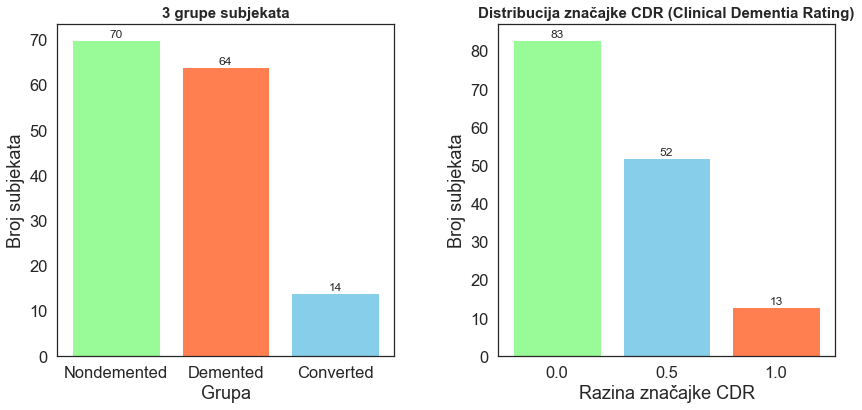

In [88]:

prvo_snimanje = data2[data2.Visit == 1]

print(f"Dimenzije podataka za prvo snimanje: {prvo_snimanje.shape}")

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (13, 7))

grupe = prvo_snimanje.groupby('Group').count().loc[:,'Subject ID'].values

title_name = prvo_snimanje.groupby('Group').count().index.values

bars = ax1.bar(title_name[::-1], grupe[::-1],color = ["palegreen","coral","skyblue"])

ax1.bar_label(bars,size = 12)
ax1.set_xlabel("Grupa")
ax1.set_ylabel("Broj subjekata")
ax1.set_title("3 grupe subjekata", weight="bold")
ax1.title.set_fontsize(15)

 
frekvencija = prvo_snimanje.groupby('CDR').count().loc[:,'Subject ID'].values
razine = prvo_snimanje.groupby('CDR').count().index.values
razine = [str(i) for i in razine]

bars = ax2.bar(razine, frekvencija, color =["palegreen","skyblue","coral"])
ax2.bar_label(bars,size = 12)
ax2.set_xlabel("Razina značajke CDR")
ax2.set_ylabel("Broj subjekata")
ax2.set_title("Distribucija značajke CDR (Clinical Dementia Rating)",weight="bold")
ax2.title.set_fontsize(15)

plt.tight_layout(pad = 3.0)
plt.show()

Kako bih sažeto prikazala podatkovni skup iskoristila sam **osnovnu deskripitvnu statistiku** (minimalnu vrijednost, maksimalnu vrijednost, medijan, aritmetičku sredinu, standardnu devijaciju) i stekla prvi uvid u podatke. Za kategorijske varijable sam pogledala distribuciju pojedine kategorije.


In [89]:
prvo_snimanje.describe()
#data2.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,148.0,148.0,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,1.0,0.0,75.256757,14.479730,2.533784,27.554054,0.263514,1471.101351,0.736581,1.208514
std,0.0,0.0,7.409427,2.807835,1.102968,2.985871,0.327046,170.670337,0.036438,0.136196
min,1.0,0.0,60.000000,6.000000,1.000000,17.000000,0.000000,1123.000000,0.660000,0.897000
25%,1.0,0.0,70.000000,12.000000,2.000000,26.000000,0.000000,1345.750000,0.710000,1.125000
50%,1.0,0.0,75.000000,14.000000,3.000000,29.000000,0.000000,1450.000000,0.736500,1.210500
75%,1.0,0.0,80.000000,16.000000,3.000000,30.000000,0.500000,1559.750000,0.758250,1.304250
max,1.0,0.0,96.000000,20.000000,5.000000,30.000000,1.000000,1957.000000,0.837000,1.563000


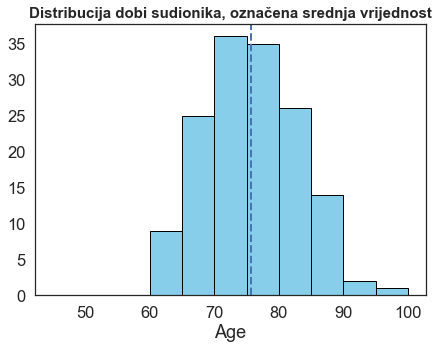

In [90]:
plt.figure(figsize = (7,5))
bins = [45,50,55,60,65,70,75,80,85,90,95,100]
plt.hist(prvo_snimanje.Age,bins = bins,edgecolor='black',color = "skyblue")
plt.xlabel('Age')
plt.axvline(prvo_snimanje[prvo_snimanje.CDR == 1].Age.mean(), color='b', linestyle='dashed', linewidth=2)
plt.title("Distribucija dobi sudionika, označena srednja vrijednost", size = 15, weight ="bold")

plt.show()

U ovom se članku koriste podatci iz longitudinalne studije provedene na 150 odraslih u dobi od 60 do 96 godina. Uklanjanjem stršećih vrijednosti ostali su podatci s prvog snimanja za 148 ljudi. 

Prosječna dob ispitanika je 75 godina. 

Medijan godina obrazovanja je 14 godina. 

Medijan na rezultatu MMSE je 29 bodova što jako visok rezultat - očekivano jer je samo 13 ispitanika imalo veću razinu demencije na prvom snimanju.

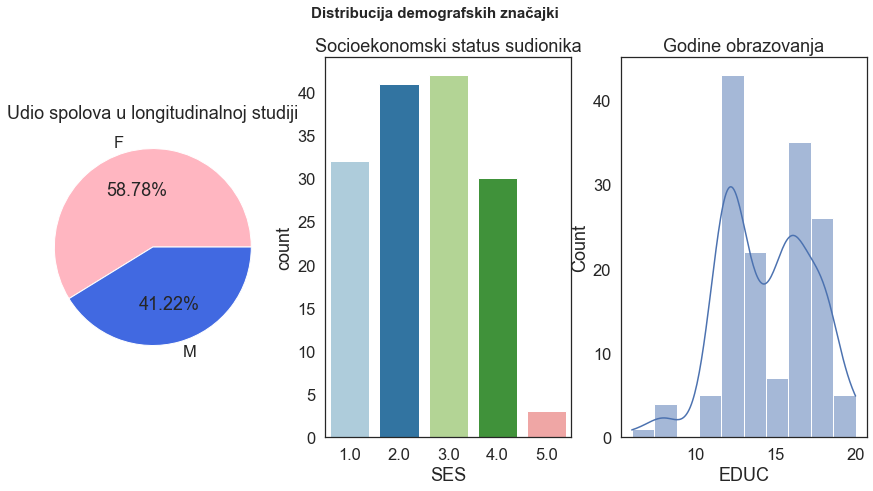

In [91]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15, 7))
plt.suptitle ("Distribucija demografskih značajki",fontsize = 15, weight = "bold")

count_per_gender = prvo_snimanje.groupby('Gender').count().loc[:,'Visit'].values
gender = prvo_snimanje.groupby('Gender').count().index.values
percent = (count_per_gender/len(prvo_snimanje))*100

ax1.pie(percent, labels=gender, autopct='%.2f%%',colors = ["lightpink","royalblue"] )
ax1.set_title("Udio spolova u longitudinalnoj studiji")





sns.countplot(data=prvo_snimanje, x="SES",palette = "Paired", ax = ax2).set_title("Socioekonomski status sudionika");
sns.histplot(data=prvo_snimanje, x="EDUC", kde=True,ax = ax3).set_title("Godine obrazovanja");

U studiji je sudjelovalo 59% žena.

Među ispitanicima su većinom ljudi srednjeg socioekonomskog statusa: razina 2 i 3. Udio izrazito bogatih (razina 5) je zanemariv, a onih najniže razina ima 22%.

Distribucija godina obrazovanja je bimodalna, većina ispitanika se obrazovala više od 12 godina.

S obzirom da je cilj rada previdjeti Alzheimer, odlučila sam proučiti kakvav je utjecaj pojedinih varijabli na demenciju.

In [92]:
print(pd.crosstab(prvo_snimanje['Group'],prvo_snimanje['Gender']))
print(pd.crosstab(prvo_snimanje['Group'], prvo_snimanje['SES']))
print(pd.crosstab(prvo_snimanje['Group'], prvo_snimanje['CDR'],))

Gender        F   M
Group              
Converted    10   4
Demented     28  36
Nondemented  49  21
SES          1.0  2.0  3.0  4.0  5.0
Group                               
Converted      7    3    3    1    0
Demented      11   12   23   16    2
Nondemented   14   26   16   13    1
CDR          0.0  0.5  1.0
Group                     
Converted     13    1    0
Demented       0   51   13
Nondemented   70    0    0


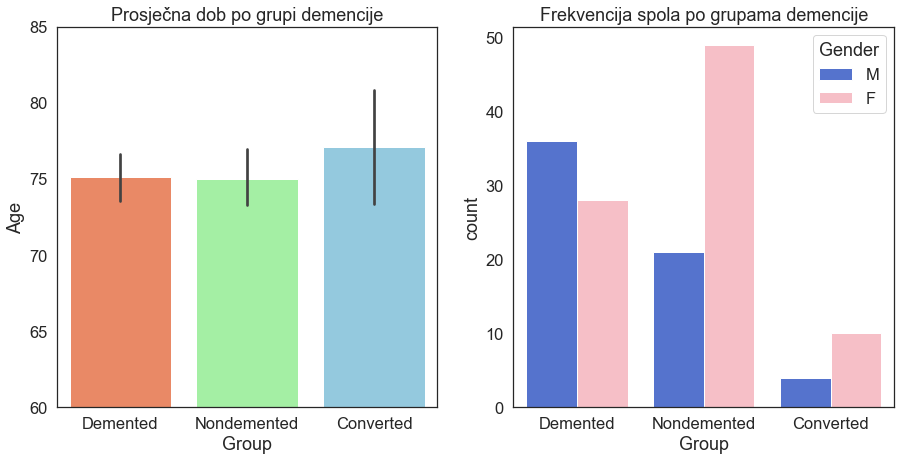

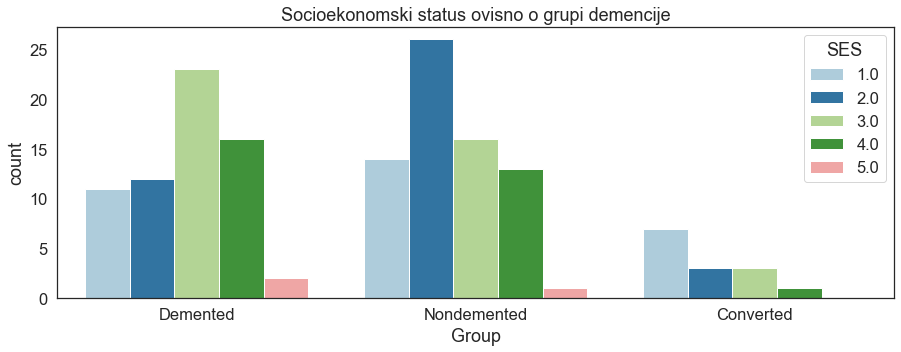

In [93]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15, 7))
ax1.set(ylim=(60,85))
bar = sns.barplot(
    data=prvo_snimanje, x="Group", y="Age", palette = ["coral","palegreen","skyblue"],
   ax = ax1)
bar.set_title ("Prosječna dob po grupi demencije");

sns.countplot(data=prvo_snimanje, x="Group", hue="Gender", ax = ax2,
              palette = ["royalblue","lightpink"]).set_title("Frekvencija spola po grupama demencije")

sns.color_palette("Set3", 5)
fig = plt.figure(figsize = (15,5))
sns.countplot(data=prvo_snimanje, x="Group", hue="SES",palette = "Paired").set_title("Socioekonomski status ovisno o grupi demencije");

Prosječna dob se ne razlikuje značajno među ispitanicama na prvom snimanju. Oni koji su u narednom razdoblju postali dementni (grupa Converted) su nešto stariji - hipoteza: Alzheimer se javlja u starijoj dobi.

Među dementnima (od početka) je više muškaraca. Među onima koji su postali dementni je više žena.

Među dementnima prevladavaju oni više razine obrazovanja (od 3 nadalje), dok među onima koji nisu dementni prevladava 2. kategorija. U grupi Converted prevladava prva kategorija.

Za spol i socioekonomski status sam htjela provjeriti jesu li nezavisni s grupom demencije. Za to mogu iskoristiti neparametarski statistički test *chi* square test. Nulta hipoteza je da su značajke nezavisne.
Pokazalo se da možemo odbaciti H0 -> spol i grupa demencije nisu nezavisni.
Za socioekonomski status se pokazalo da ne možemo odbaciti H0, iako je p vrijednost 0.055 pa tu treba biti oprezan s zaključcima.

In [94]:
spol_demencija = pd.crosstab(prvo_snimanje['Group'],prvo_snimanje['Gender'])
stat, p, dof, expected = chi2_contingency(spol_demencija)
alpha = 0.05
print("p value is " + str(round(p,3)))
if p <= alpha:
    print('Značajke (spol i demencija) su zavisne.')
else:
    print('Značajke (spol i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)')
    
ses_demencija = pd.crosstab(prvo_snimanje['Group'],prvo_snimanje['SES'])
stat, p, dof, expected = chi2_contingency(ses_demencija)
#print(ses_demencija)

print("p value is " + str(round(p,3)))
if p <= alpha:
    print('Značajke (SES i demencija) su zavisne.')
else:
    print('Značajke (SES i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)')

p value is 0.005
Značajke (spol i demencija) su zavisne.
p value is 0.055
Značajke (SES i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)


Paralelnim koordinatama sam prikazala kako se odnose značajke MMSE, CDR, nWBV, Age i eTIV. Jasno se vidi da osobe s demencijom imaju manju značajku nWBV koja opisuje volumen mozga. Za dob i tu značajku bismo mogli reći da su obrnuto proporcionalne. Za značajku MMSE i CDR bismo također mogli reći da su obrnuto proporcionalne.

In [111]:
import plotly.express as px
X_tmp = prvo_snimanje.loc[:, ['MMSE','CDR','nWBV','Age','eTIV']]
fig = px.parallel_coordinates(X_tmp, color="CDR", labels={"MMSE": "MMSE",
                  "Age": "Age", "CDR": "CDR",
                  "eTIV": "eTIV", "nWBV": "nWBV", },
                    color_continuous_scale=px.colors.diverging.Tropic, range_color=[0,1])
fig.show()

Zanimalo me kako se mijenja rezultat na MMSE ovisno o spolu i razini demencije.

Po razinama demencije nema razlike u spolu, ali se rezultat značajno smanjuje kako raste razina demencije.

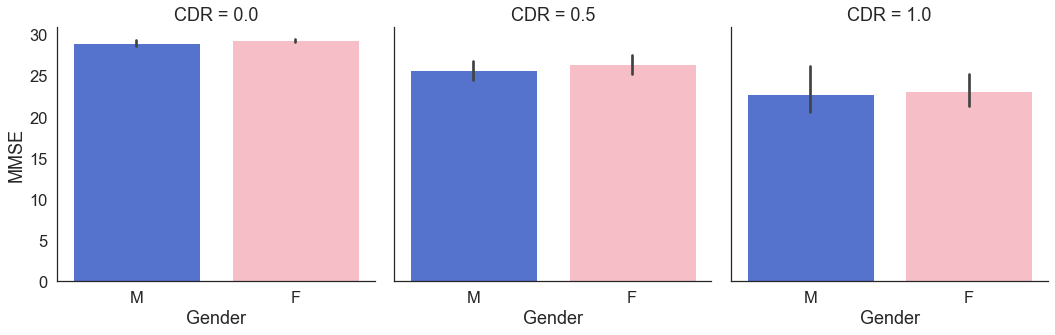

In [96]:

sns.catplot(
    data=prvo_snimanje, x="Gender", y="MMSE", col="CDR",kind = "bar", 
    palette = ["royalblue","lightpink"]
)



Napravila sam binarnu značajku Demented (prema značajci CDR) kako bismo znali je li osoba dementna u trenutku snimanja.

In [97]:
#je li na prvom snimanju već imao demenciju

def demented(row):
    if row.CDR >= 0.5:
        return "Demented"
    else:
        return "Nondemented"
 
prvo_snimanje.loc[:,'Demention'] = prvo_snimanje.apply(lambda row: demented(row), axis=1)


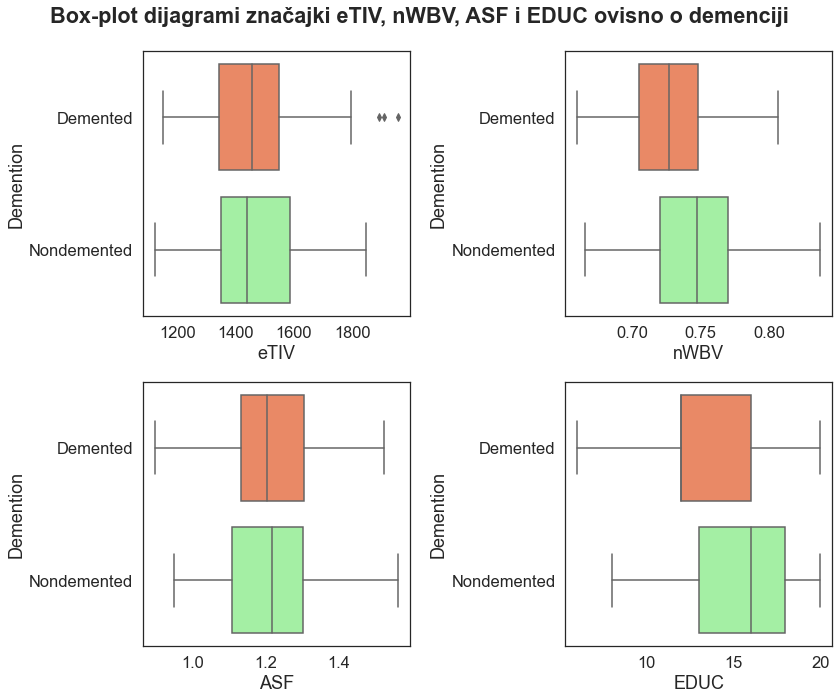

In [98]:

fig = plt.figure(figsize = (12,10))
fig.suptitle("Box-plot dijagrami značajki eTIV, nWBV, ASF i EDUC ovisno o demenciji",weight = "bold")

ax1 = fig.add_subplot(221)
sns.boxplot(data=prvo_snimanje, x="eTIV", y="Demention",ax = ax1,palette = ["coral","palegreen"])
ax2 = fig.add_subplot(222)
sns.boxplot(data=prvo_snimanje, x="nWBV", y="Demention",ax = ax2, palette = ["coral","palegreen"])
ax3 = fig.add_subplot(223)
sns.boxplot(data=prvo_snimanje, x="ASF", y="Demention",ax = ax3, palette = ["coral","palegreen"])
ax3 = fig.add_subplot(224)
sns.boxplot(data=prvo_snimanje, x="EDUC", y="Demention",ax = ax3, palette = ["coral","palegreen"])
plt.tight_layout()


Distribucija značajke eTIV je slična za obje skupine. 
Normalizirani volumen mozga je značajno veći za nedementne pojednce.
Može se primjetiti da za ASF nema značajne razlike ovisno o demenciji. 
Primjeti se da je gornji kvartil (i medijan) godina obrazovanja veći za one koji nisu dementnti.

In [99]:
# Shapiro-Wilk test normalnosti
from scipy.stats import shapiro
def normal(znacajka):
    print(f"Normalnost značajke {znacajke} za (ne)dementne:")
    dementni = prvo_snimanje[prvo_snimanje.Demention == "Demented"][znacajka]
    nedementni = prvo_snimanje[prvo_snimanje.Demention == "Nondemented"][znacajka]
    stat, p = shapiro(nedementni)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Gaussian')
    else:
        print('not Gaussian')
    stat, p = shapiro(dementni)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Gaussian')
    else:
        print('not Gaussian')
    
#znacajke = ["eTIV", "nWBV", "ASF", "EDUC","Age"]
#for i in znacajke:
#    normal(i)
#def ttest(znacajka):
    

    dementni = prvo_snimanje[prvo_snimanje.Demention == "Demented"][znacajka]
    nedementni = prvo_snimanje[prvo_snimanje.Demention == "Nondemented"][znacajka]

    statistic, p  = stats.ttest_ind(dementni, nedementni)
    print(f"p-vrijednost: {p:.5f}")
    if p > 0.5:
        print(f"Srednje vrijednosti uzoraka za značajku {znacajka} su jednake.")
    else:
        print(f"Srednje vrijednosti uzoraka za značajku {znacajka} nisu jednake.")
        
znacajke = ["eTIV", "nWBV", "ASF", "EDUC"]
for i in znacajke:
    ttest(i)

p-vrijednost: 0.86323
Srednje vrijednosti uzoraka za značajku eTIV su jednake.
p-vrijednost: 0.00043
Srednje vrijednosti uzoraka za značajku nWBV nisu jednake.
p-vrijednost: 0.86322
Srednje vrijednosti uzoraka za značajku ASF su jednake.
p-vrijednost: 0.00150
Srednje vrijednosti uzoraka za značajku EDUC nisu jednake.


S obzirom da su značajke ASF, nWBV i eTIV približno normalno distribuirane (po Shapiro-Wilk testu), mogla sam t-testom provjeriti razlikuju li se srednje vrijednosti tih značaji za grupe demencije.
Doista, srednje vrijednosti za značajke eTIV i ASF su jednake i za dementnu i nedementnu grupu.
Za značajku nWBV nisu jednake, kao ni za značajku EDUC (iako ta značajka nije normalno distribuirna).

      AgeCategory       CDR
0  (59.964, 67.2]  0.250000
1    (67.2, 74.4]  0.270833
2    (74.4, 81.6]  0.270000
3    (81.6, 88.8]  0.261905
4    (88.8, 96.0]  0.214286
p-vrijednost: 0.66137
Srednje vrijednosti uzoraka za značajku Age su jednake.


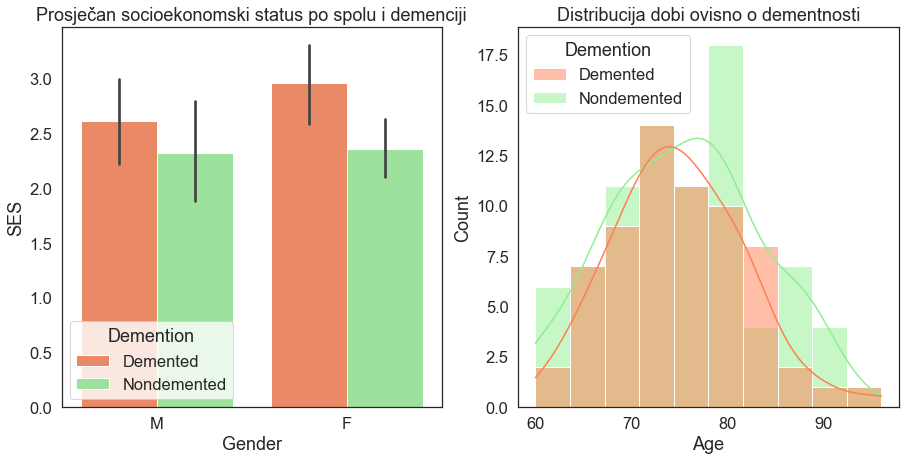

In [100]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15, 7))

sns.barplot(
    data=prvo_snimanje, x="Gender", y="SES", hue = "Demention", ax = ax1,
    palette = ["coral","lightgreen"]).set_title("Prosječan socioekonomski status po spolu i demenciji")
sns.histplot(data= prvo_snimanje, x="Age", kde=True, hue = "Demention", ax = ax2, palette = ["coral","lightgreen"]).set_title("Distribucija dobi ovisno o dementnosti")
prvo_snimanje['AgeCategory'] = pd.cut(prvo_snimanje['Age'], 5)
# prikažimo ovisnost s demencijom
print(prvo_snimanje[['AgeCategory', 'CDR']].groupby(by='AgeCategory',as_index=False).mean().sort_values(by='AgeCategory', ascending=True))
ttest("Age")

Neovisno o spolu dementni imaju prosječno viši socioekonomski status.

Na prvom je snimanju među dementnima bilo najviše 70godišnjaka,a distribucije dobi nisu značajno različite. Prema t-testu srednje vrijednosti dementnih i nedementnih sudionika su jednake.

Odlučila sam prikazati 3 scatterplota. Pomoću njih možemo vidjeti postoji li veza između odabrane 2 značajke te između njih i demencije.

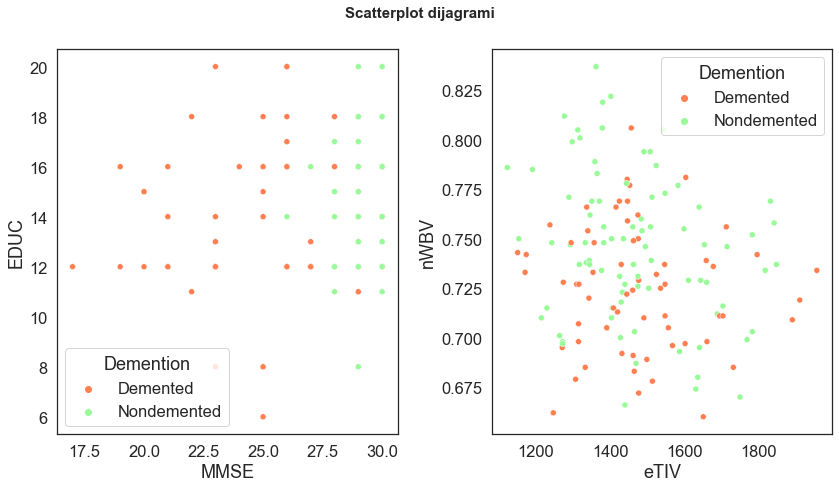

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 7))
plt.suptitle ("Scatterplot dijagrami",fontsize = 15, weight = "bold")
#MMSE vs EDUC

sns.scatterplot( x="MMSE", y="EDUC", ax = ax1, data=prvo_snimanje,  hue='Demention',palette = ["coral","palegreen"])

#eTIV vs nWBV

sns.scatterplot( x="eTIV", y="nWBV", ax = ax2, data=prvo_snimanje, hue='Demention',palette = ["coral","palegreen"])
plt.tight_layout()



Opažanja:
* dementni pojedenici imaju značajno lošiji rezultat na MMSE (neovisno o godinama obrazovanja)
* značajka nWBV je prosječno manja za dementne pojedince, čine se da nema veze između te značajke i eTIV
* s godinama se nWBV smanjuje

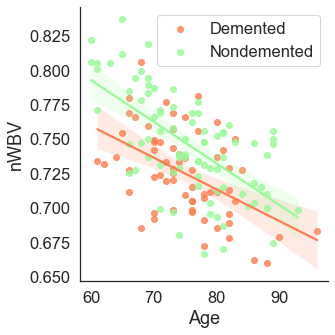

In [102]:
#nWBV vs Age
sns.lmplot( x="Age", y="nWBV", data=prvo_snimanje,  hue='Demention',legend =False,palette = ["coral","palegreen"])
plt.legend(loc='best')
plt.show()


In [103]:
#istraživanje pojedinaca koji su bili na više snimanje, za dementne se jasno vidi pad značajki MMSE i nWBV
#print(data2[data2["Subject ID"] == "OAS2_0048"])-BIO JE NA 5 SNIMANJA
#na4snimanja = data2[data2.Visit == 4]["Subject ID"]
#print(len(na4snimanja))
#for i in na4snimanja:
#    print(i)
#    print(data2[data2["Subject ID"] == i])


Zanimljivo mi se činilo proučiti kako se mijenjaju (po posjetima) pojedine značajke za grupu Converted jer se kod njih demencija tek razvila za vrijeme istraživanja. Prikazala sam značajke MMSE, eTIV, nWBV i dob po posjetima za tu grupu. 

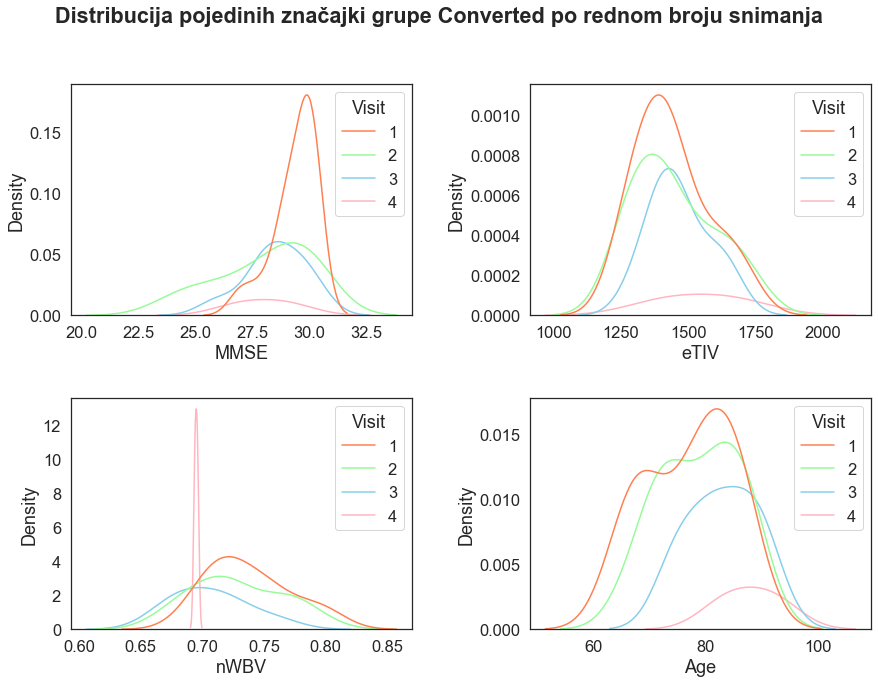

In [104]:
fig, ax = plt.subplots(2,2,figsize = (13, 10))
plt.suptitle("Distribucija pojedinih značajki grupe Converted po rednom broju snimanja", weight ="bold")
sns.kdeplot(
    data=data2[data2.Group == "Converted"], x="MMSE", hue="Visit",palette = ["coral","palegreen","skyblue","lightpink"],
    ax = ax[0,0])

sns.kdeplot(
    data=data2[data2.Group == "Converted"], x="eTIV", hue="Visit",palette = ["coral","palegreen","skyblue","lightpink"],
        ax = ax[0,1])

sns.kdeplot(
    data=data2[data2.Group == "Converted"], x="nWBV", hue="Visit", palette = ["coral","palegreen","skyblue","lightpink"],
    ax = ax[1,0])

sns.kdeplot(
    data=data2[data2.Group == "Converted"], x="Age", hue="Visit", palette = ["coral","palegreen","skyblue","lightpink"],
    ax = ax[1,1]
)

plt.tight_layout(pad = 2.0)

Budući da se radi o longitudinalnom istraživanju, sudionici su očekivano prosječno stariji u odnosu na prvi posjet.

Može se primijetiti da se MMSE rezultat pogoršava po rednom broju posjeta. 
Za eTIV nema značajne razlike u distribuciji, minimalan porast.
Za normalizirani volumen mozga se jasno vidi da se smanjuje u odnosu na prvi posjet. Ovo potvrđuje da je Alzheimer progresivna degenerativna bolest.

Prije treniranja modela važno je bilo provesti eksploratornu analizu podatkovnog skupa. Već se vizualnom inspekcijom mogu zaključiti koje bi značajke bile dobri prediktori bolesti.

Provjerila sam ima li korelacije pojedinih značajki i izlazne varijable (Demention).
Korisno je provjeriti i ima li korelacije među pojedinim značajkama kako bi izbjegli multikoreliranost.

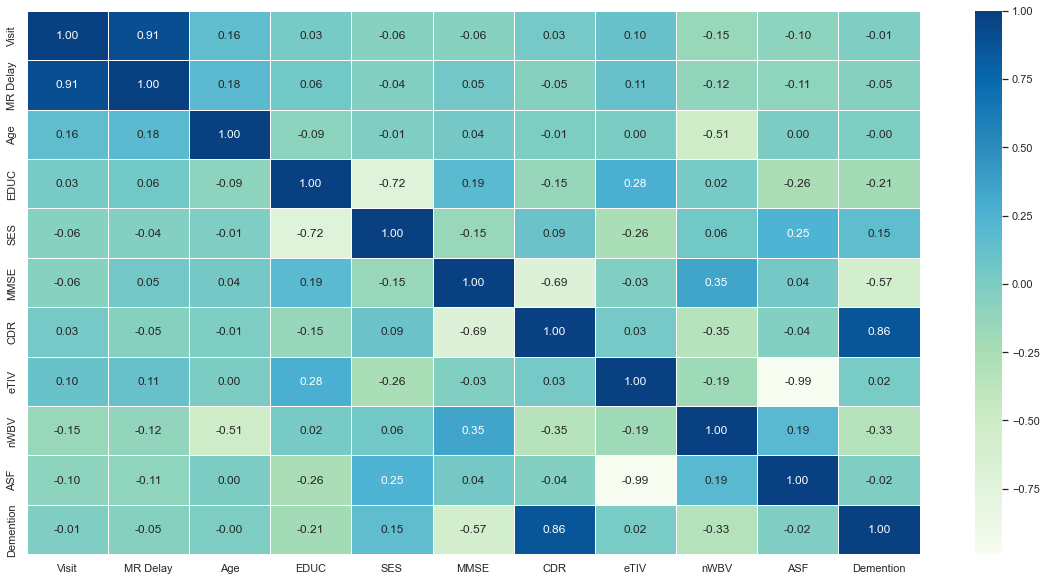

In [105]:
data2.loc[:,'Demention'] = data2.apply(lambda row: demented(row), axis=1)
data2.loc[data2['Demention'] == "Demented", 'Demention'] = 1
data2.loc[data2['Demention'] == "Nondemented", 'Demention'] = 0
data2["Demention"] = pd.to_numeric(data2["Demention"])

data_numeric = data2.loc[:,~data2.columns.isin(['Subject ID',"Group",'Gender'])]
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(data_numeric.corr(), annot=True, fmt=".2f", cmap="GnBu", linewidths=.5)
plt.show()

Postoji jaka korelacija između broja posjeta i MRDelay, a gotovo nikakva između tih varijabli i izlazne pa se te varijable mogu izbaciti iz modela. 

Postoji nezanemariva negativna korelacija između socioekonomskog statusa i godina obrazovanja.

Postoji nezanemariva negativna korelacija između MMSE i CDR koji se već po vizualizacijama pokazao kao dobar prediktor. Također, nWBV je očito dobar prediktor.

Postoji izrazito jaka negativna korelacija (-0.99) između faktora ASF i eTIV, ali ni jedan od njih se (na prvi pogled) ne čini korisnim za klasifikaciju. Autori članka su odlučili koristi eTIV, a onda razumljivo njemu jako kolerirani ASF nisu.


In [110]:
# inicijalizacija enkodera

le = LabelEncoder()
le.fit(data.loc[:,'Gender'])


LabelEncoder()